In [ ]:
# Google Colab Template:
# 1. Turn on GPU from Runtime -> Change runtime type -> GPU
# 2. Import Google Drive
from google.colab import drive
drive.mount('/content/drive')

# 3. Copy the required content (datasets) from the drive (zip format)
!cp /content/drive/MyDrive/ML/ai-unibuc-23-31-2021.zip /content

# 4. Unzip the data from the copied .zip file for Colab local acces (faster dataset loading)
!unzip ai-unibuc-23-31-2021.zip

In [ ]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as functional
import numpy as np
from PIL import Image
import csv
from tqdm.notebook import trange, tqdm         
import os
import shutil

In [ ]:
# Fisierele de inputs
TRAIN_FOLDER = "./train"
TEST_FOLDER = "./test"
VALIDATION_FOLDER = "./validation"
TRAIN_LABELS = "./train.txt"
TEST_LABELS = "./test.txt"            # No labels
VALIDATION_LABELS = "./validation.txt"
RESHAPE_SIZE = 2500

In [ ]:
# Citirea imaginilor si datelor din fisiere
def read_images(path, files):
    if not os.path.isdir(path):
        raise Exception("Path-ul specificat nu este un folder")
    return torch.tensor([cv2.imread(f"{path}/{img}", 0).reshape(RESHAPE_SIZE) for img in files])

def read_csv_file(path):
    if not os.path.isfile(path):
        raise Exception("Path-ul specificat nu este un fisier")
    with open(path) as csv_file:
        data = np.array(list(csv.reader(csv_file)))
    return data

def split_csv_data(data):
    return data[:, 0], torch.tensor(data[:, 1].astype(int))

In [ ]:
# Transformations
train_data_transform = torchvision.transforms.Compose([
    # torchvision.transforms.Grayscale(num_output_channels=1),
    # torchvision.transforms.ToPILImage(),
    torchvision.transforms.Resize(350),
    torchvision.transforms.CenterCrop(330),
    torchvision.transforms.RandomRotation(23),
    torchvision.transforms.RandomHorizontalFlip(0.075),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
    # torchvision.transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

validation_data_transform = torchvision.transforms.Compose([
    # torchvision.transforms.ToPILImage(),
    torchvision.transforms.Resize(350),
    torchvision.transforms.CenterCrop(330),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
    # torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

In [ ]:
# Custom dataset
class DatasetCTScanKaggleNicuDucal(torch.utils.data.Dataset):
    def __init__(self, date_despre_set, folder_poze, transformari=None):
        self.nume_labeluri = read_csv_file(date_despre_set)
        self.folder_poze = folder_poze
        self.transformari = transformari
    
    def __len__(self):
        return len(self.nume_labeluri)
    
    def __getitem__(self, poz):
        path_imagine = os.path.join(self.folder_poze, self.nume_labeluri[poz, 0])
        imagine = Image.open(path_imagine).convert('RGB')
        if self.nume_labeluri[poz].size == 1:
            label = torch.tensor(-1)
        else:
            label = torch.tensor(int(self.nume_labeluri[poz, 1]))
        if self.transformari:
            imagine = self.transformari(imagine)
        obiect = (imagine, label)
        return obiect

In [ ]:
trainset = DatasetCTScanKaggleNicuDucal("train.txt", "train", train_data_transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)

validationset = DatasetCTScanKaggleNicuDucal("validation.txt", "validation", validation_data_transform)
validationloader = torch.utils.data.DataLoader(validationset, batch_size=32, shuffle=False)

testset = DatasetCTScanKaggleNicuDucal("test.txt", "test", validation_data_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False)

In [ ]:
train_features, train_labels = next(iter(testloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

Feature batch shape: torch.Size([32, 3, 512, 512])
Labels batch shape: torch.Size([32])


In [ ]:
##################### MODELE ###############################

In [ ]:
# AlexNet
advanced_network = torchvision.models.AlexNet(3).cuda()
advanced_network

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
# VGG19 With BN
advanced_network = torchvision.models.vgg19_bn(pretrained=True).cuda()
last_layer = advanced_network.classifier[6].in_features
advanced_network.classifier[6] = nn.Linear(in_features=last_layer, out_features=3).cuda()

In [ ]:
# ResNet with Transfer Learning
advanced_network = torchvision.models.resnet101(pretrained=False).cuda()
last_layer = advanced_network.fc.in_features
advanced_network.fc = nn.Linear(in_features=last_layer, out_features=3).cuda()

In [ ]:
# Inception
advanced_network = torchvision.models.inception_v3(pretrained=True).cuda()
last_layer = advanced_network.fc.in_features
advanced_network.fc = nn.Linear(in_features=last_layer, out_features=3).cuda()

In [ ]:
# GoogleNet
advanced_network = torchvision.models.googlenet(pretrained=True).cuda()
last_layer = advanced_network.fc.in_features
advanced_network.fc = nn.Linear(in_features=last_layer, out_features=3).cuda()

Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth


In [ ]:
# DenseNet
advanced_network = torchvision.models.densenet161(pretrained=True).cuda()
last_layer = advanced_network.classifier.in_features
advanced_network.classifier = nn.Linear(in_features=last_layer, out_features=3).cuda()

Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to /root/.cache/torch/hub/checkpoints/densenet161-8d451a50.pth


In [ ]:
# Definirea datelor
# advanced_network = AdvancedConvolutionalNeuralNetwork().cuda()
# advanced_network = VGG_Simple().cuda()
# advanced_network = VGG_CNN().cuda()
loss_function = nn.CrossEntropyLoss().cuda()

In [ ]:
# Optimizer
learning_rate = 1e-5
optimizer_function = torch.optim.Adam(advanced_network.parameters(), lr=learning_rate)
# optimizer_function = torch.optim.Adadelta(advanced_network.parameters(), lr=learning_rate)
# optimizer_function = torch.optim.Adagrad(advanced_network.parameters(), lr=learning_rate)
# optimizer_function = torch.optim.SGD(advanced_network.parameters(), lr=learning_rate, nesterov=True, momentum=0.9)

In [ ]:
# Loss and accuracy pentru plot
train_losses = []
train_accuracy = []
validation_losses = []
validation_accuracy = []

In [ ]:
# Matricea de confuzie
def confunsion_matrix(predicted_labels, ground_truth_labels):
    num_labels = ground_truth_labels.max() + 1
    conf_mat = torch.from_numpy(np.zeros((num_labels, num_labels))).cuda()

    # print(predicted_labels, ground_truth_labels)
    for i in range(len(predicted_labels)):
        conf_mat[ground_truth_labels[i], predicted_labels[i]] += 1
    return conf_mat

all_confusion_matrices = []

In [ ]:
# Functie pentru evaluarea modelului pe validation data
def evaluate_model(data):
    advanced_network.eval()
    accuracy = 0
    total = 0
    loss_rate = 0.0
    with torch.no_grad():
        confusion_matrice = torch.from_numpy(np.zeros((3, 3))).cuda()
        for photos, labels in tqdm(data):
            photos = photos.cuda()
            labels = labels.cuda()
            y_predictions = advanced_network(photos)
            loss = loss_function(y_predictions, labels)
            confusion_matrice += confunsion_matrix(y_predictions.argmax(dim=1), labels)
            loss_rate += loss.item()
            accuracy += torch.sum(y_predictions.argmax(dim=1) == labels)
            total += len(photos)
        print(f"Loss = {loss_rate / len(data)}, Accuracy = {accuracy / total}")
        validation_losses.append(loss_rate / len(data))
        validation_accuracy.append(accuracy / total)
        all_confusion_matrices.append(confusion_matrice)

In [ ]:
# Functie care face predictiile pentru test data
def compute_predictions(data):
    advanced_network.eval()
    labels = torch.tensor([]).cuda()
    with torch.no_grad():
        for photos, fake_labels in tqdm(data):
            photos = photos.cuda()
            y_predictions = advanced_network(photos)
            labels = torch.cat((labels, torch.argmax(y_predictions, dim=1)))
        return labels

In [ ]:
# Write to submission file
# !mkdir submissions_folder
if not os.path.isdir("submissions_folder"):
    os.mkdir("submissions_folder")

def write_to_file(epoch, test_labels):
    with open(f"submissions_folder/submission_epoch_{epoch}.csv", "w") as csvfile:
        csvfile.write("id,label\n")
        for i in range(len(test_labels)):
            # file_name = testloader.dataset.samples[i][0].split("/")[-1]
            file_name = testloader.dataset.nume_labeluri[i][0]
            label = int(test_labels[i])
            # print(file_name, label)
            csvfile.write(f"{file_name},{label}\n")

In [ ]:
# Functia care antreneaza modelul
def train_model(data, epochs):
    global train_losses, train_accuracy, validation_losses, validation_accuracy, all_confusion_matrices
    # Initializarea datelor
    train_losses = []
    train_accuracy = []
    validation_losses = []
    validation_accuracy = []
    all_confusion_matrices = []
    loss_rate = 0.0
    correct_labels = 0
    total_data = 0
    total_batches = len(data)
    for epoch in trange(epochs, desc="Epoch:"):
        advanced_network.train()
        for photos, labels in tqdm(data):
            photos = photos.cuda()
            labels = labels.cuda()
            y_predictions = advanced_network(photos)
            correct_labels += torch.sum(y_predictions.argmax(dim=1) == labels)
            total_data += len(photos)
            loss = loss_function(y_predictions, labels)
            loss_rate += loss.item()

            # Learning
            optimizer_function.zero_grad()
            loss.backward()
            optimizer_function.step()
        print(f"Epoch {epoch}, Loss = {loss_rate / total_batches}, Accuracy = {correct_labels / total_data}")
        train_losses.append(loss_rate / total_batches)
        train_accuracy.append(correct_labels / total_data)
        loss_rate = 0.0
        correct_labels = 0
        total_data = 0
    
        # Testing on validation
        print(f"Validation after epoch {epoch}: ")
        evaluate_model(validationloader)

        # Making submissions
        test_labels = compute_predictions(testloader).cpu().numpy()
        write_to_file(epoch, test_labels)

In [ ]:
# Antrenarea
train_model(trainloader, 30)


Epoch 0, Loss = 0.825191271965946, Accuracy = 0.5776000022888184
Validation after epoch 0: 



Loss = 0.5665537972822257, Accuracy = 0.7351111173629761



Epoch 1, Loss = 0.43043875843604235, Accuracy = 0.8087999820709229
Validation after epoch 1: 



Loss = 0.4039175141576334, Accuracy = 0.816444456577301



Epoch 2, Loss = 0.272532260097039, Accuracy = 0.8826666474342346
Validation after epoch 2: 



Loss = 0.3941240765629931, Accuracy = 0.8366667032241821



Epoch 3, Loss = 0.18689781308237677, Accuracy = 0.921999990940094
Validation after epoch 3: 



Loss = 0.3294410396182368, Accuracy = 0.8653333187103271



Epoch 4, Loss = 0.14193362677529422, Accuracy = 0.9422667026519775
Validation after epoch 4: 



Loss = 0.37744858702446554, Accuracy = 0.8568888902664185



Epoch 5, Loss = 0.11061227684721414, Accuracy = 0.9549333453178406
Validation after epoch 5: 



Loss = 0.3600715542648067, Accuracy = 0.8659999966621399



Epoch 6, Loss = 0.08983151502420765, Accuracy = 0.9624666571617126
Validation after epoch 6: 



Loss = 0.4249061949101957, Accuracy = 0.8651111125946045



Epoch 7, Loss = 0.08094370462941622, Accuracy = 0.9696666598320007
Validation after epoch 7: 



Loss = 0.3470504364553601, Accuracy = 0.8871111273765564



Epoch 8, Loss = 0.06499788621718537, Accuracy = 0.9753333330154419
Validation after epoch 8: 



Loss = 0.525709216727327, Accuracy = 0.8577777743339539



Epoch 9, Loss = 0.058263878315823206, Accuracy = 0.9763333201408386
Validation after epoch 9: 



Loss = 0.5430456108103195, Accuracy = 0.8600000143051147



Epoch 10, Loss = 0.054807040629896525, Accuracy = 0.979533314704895
Validation after epoch 10: 



Loss = 0.42437244810705593, Accuracy = 0.8768888711929321



Epoch 11, Loss = 0.044320823662831924, Accuracy = 0.9830666780471802
Validation after epoch 11: 



Loss = 0.4111481765912621, Accuracy = 0.8840000033378601



Epoch 12, Loss = 0.0419225360938052, Accuracy = 0.9841333627700806
Validation after epoch 12: 



Loss = 0.39578523419273964, Accuracy = 0.8866666555404663



Epoch 13, Loss = 0.03458020981612316, Accuracy = 0.987333357334137
Validation after epoch 13: 



Loss = 0.4073102462785781, Accuracy = 0.8853333592414856



Epoch 14, Loss = 0.03428394539430782, Accuracy = 0.9870666861534119
Validation after epoch 14: 



Loss = 0.41893704036078977, Accuracy = 0.890666663646698



Epoch 15, Loss = 0.029494458208243344, Accuracy = 0.9890000224113464
Validation after epoch 15: 



Loss = 0.5763527276787035, Accuracy = 0.8684444427490234



Epoch 16, Loss = 0.02883886777797899, Accuracy = 0.9901999831199646
Validation after epoch 16: 



Loss = 0.3902711136983245, Accuracy = 0.8937777876853943



Epoch 17, Loss = 0.027108035431133517, Accuracy = 0.9901999831199646
Validation after epoch 17: 



Loss = 0.4712200977291304, Accuracy = 0.8860000371932983



Epoch 18, Loss = 0.021781598138137667, Accuracy = 0.991266667842865
Validation after epoch 18: 



Loss = 0.4649667496470353, Accuracy = 0.8888888955116272



Epoch 19, Loss = 0.024295748292177077, Accuracy = 0.9912000298500061
Validation after epoch 19: 



Loss = 0.3806436795003197, Accuracy = 0.9017778038978577



Epoch 20, Loss = 0.021476263225970064, Accuracy = 0.9925333261489868
Validation after epoch 20: 



Loss = 0.5554817395812356, Accuracy = 0.8753333687782288



Epoch 21, Loss = 0.023387186710124783, Accuracy = 0.9922000169754028
Validation after epoch 21: 



Loss = 0.5903570137650488, Accuracy = 0.8677777647972107



Epoch 22, Loss = 0.019214800743590374, Accuracy = 0.9927999973297119
Validation after epoch 22: 



Loss = 0.496193052529492, Accuracy = 0.8837777972221375



Epoch 23, Loss = 0.020353485368506303, Accuracy = 0.9926666617393494
Validation after epoch 23: 



Loss = 0.4335177240501891, Accuracy = 0.8964444398880005



Epoch 24, Loss = 0.017845583801515644, Accuracy = 0.9932667016983032
Validation after epoch 24: 



Loss = 0.477808143952527, Accuracy = 0.8935555815696716



Epoch 25, Loss = 0.020875623268784886, Accuracy = 0.993066668510437
Validation after epoch 25: 



Loss = 0.42442569602838165, Accuracy = 0.8951111435890198



Epoch 26, Loss = 0.012294936134183906, Accuracy = 0.9959999918937683
Validation after epoch 26: 



Loss = 0.6193114322670471, Accuracy = 0.8837777972221375



Epoch 27, Loss = 0.01888560429174087, Accuracy = 0.9932000041007996
Validation after epoch 27: 



Loss = 0.4634998498138962, Accuracy = 0.8846666812896729



Epoch 28, Loss = 0.015239707125666817, Accuracy = 0.9949333667755127
Validation after epoch 28: 



Loss = 0.483606768332404, Accuracy = 0.8933333158493042



Epoch 29, Loss = 0.012920414438076186, Accuracy = 0.9954000115394592
Validation after epoch 29: 



Loss = 0.706399647972682, Accuracy = 0.8717777729034424


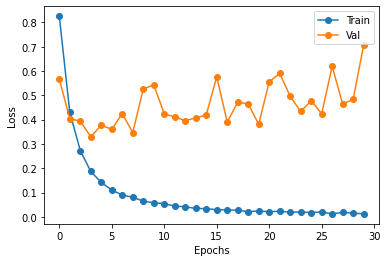

In [ ]:
# Plotare Loss
import matplotlib.pyplot as plt
epochs = range(30)
plt.plot(epochs, train_losses, label='Train', marker='o')
plt.plot(epochs, validation_losses, label='Val', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('losses.png')

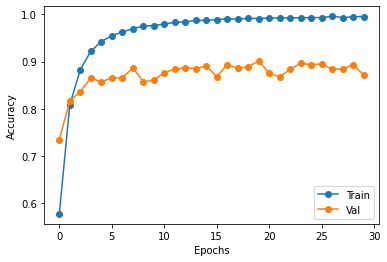

In [ ]:
# Plotare Loss
epochs = range(30)
plt.plot(epochs, train_accuracy, label='Train', marker='o')
plt.plot(epochs, validation_accuracy, label='Val', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('accuracy.png')

In [ ]:
all_confusion_matrices

[tensor([[1320.,  126.,   54.],
         [ 201.,  814.,  485.],
         [ 129.,  197., 1174.]], device='cuda:0', dtype=torch.float64),
 tensor([[1453.,   38.,    9.],
         [ 174.,  993.,  333.],
         [  62.,  210., 1228.]], device='cuda:0', dtype=torch.float64),
 tensor([[1422.,   60.,   18.],
         [  61.,  958.,  481.],
         [  17.,   98., 1385.]], device='cuda:0', dtype=torch.float64),
 tensor([[1448.,   43.,    9.],
         [  50., 1106.,  344.],
         [  21.,  139., 1340.]], device='cuda:0', dtype=torch.float64),
 tensor([[1391.,   93.,   16.],
         [  30., 1112.,  358.],
         [  15.,  132., 1353.]], device='cuda:0', dtype=torch.float64),
 tensor([[1413.,   76.,   11.],
         [  24., 1153.,  323.],
         [  16.,  153., 1331.]], device='cuda:0', dtype=torch.float64),
 tensor([[1442.,   48.,   10.],
         [  38., 1101.,  361.],
         [  22.,  128., 1350.]], device='cuda:0', dtype=torch.float64),
 tensor([[1471.,   20.,    9.],
         [  47.,